In [43]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

In [44]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 22, 7
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [45]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('aaba.us.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
data

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1996-04-12,1.05,1.790,1.02,1.38,408720000,0
1996-04-15,1.49,1.500,1.25,1.34,79231200,0
1996-04-16,1.34,1.340,1.17,1.20,48026400,0
1996-04-17,1.18,1.180,1.03,1.12,42871200,0
1996-04-18,1.25,1.250,1.17,1.22,27352800,0
...,...,...,...,...,...,...
2017-11-06,70.27,71.960,70.27,71.71,7129828,0
2017-11-07,72.20,72.470,71.62,72.22,9161521,0
2017-11-08,72.00,72.200,71.09,71.16,7363365,0


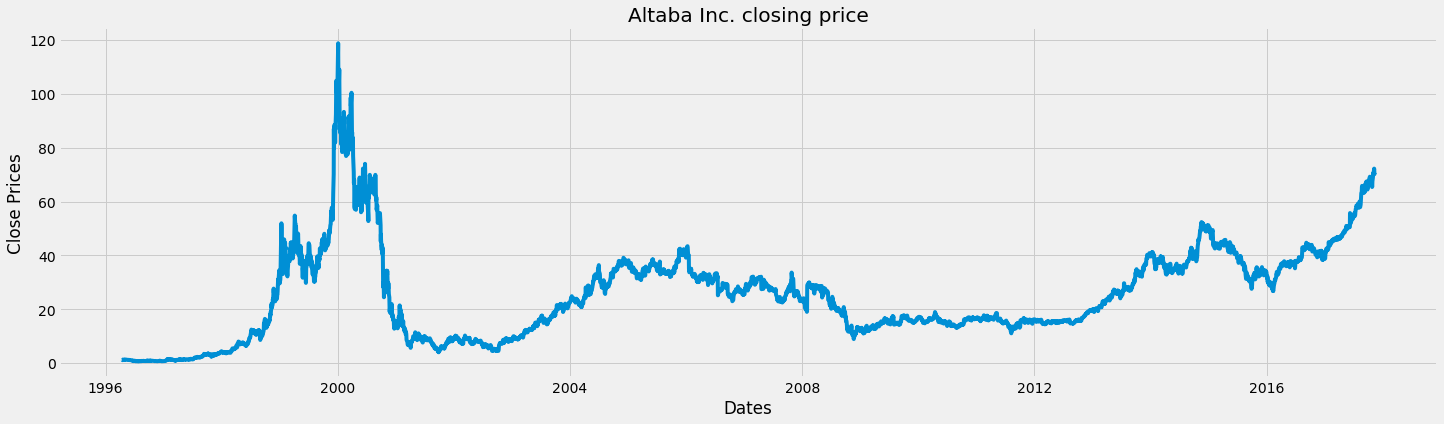

In [46]:
#plot close price
plt.figure(figsize=(22,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('Altaba Inc. closing price')
plt.show()

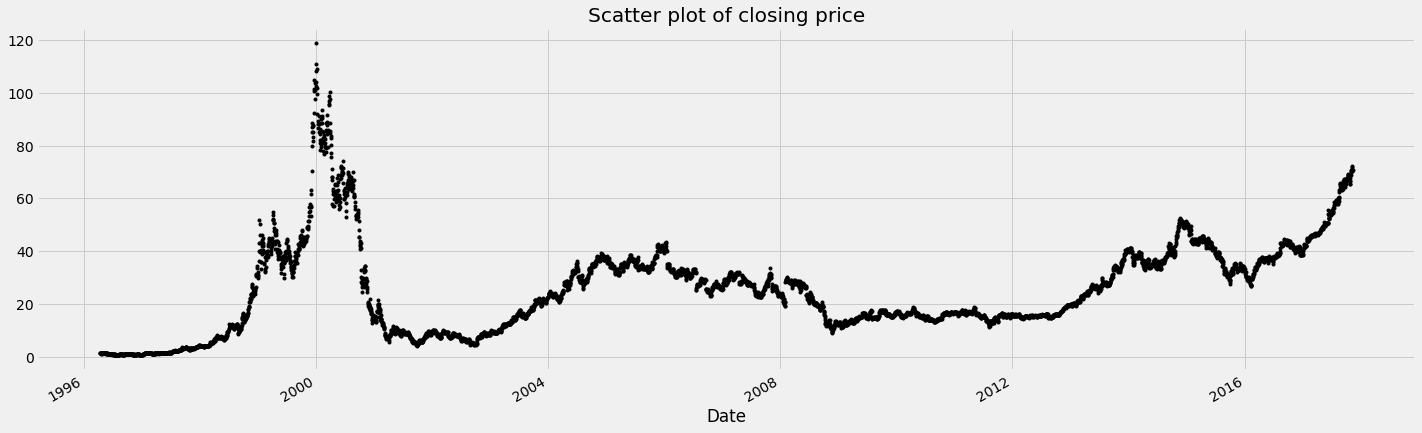

In [47]:
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

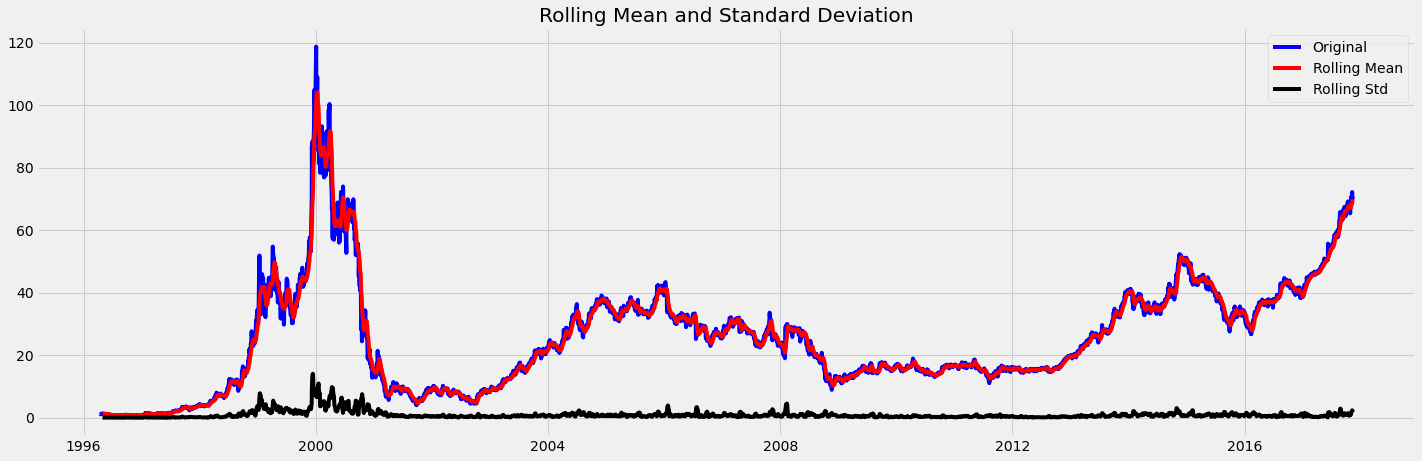

Results of dickey fuller test
Test Statistics                  -2.062280
p-value                           0.259950
No. of lags used                 32.000000
Number of observations used    5401.000000
critical value (1%)              -3.431561
critical value (5%)              -2.862075
critical value (10%)             -2.567055
dtype: float64


In [48]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 1584x504 with 0 Axes>

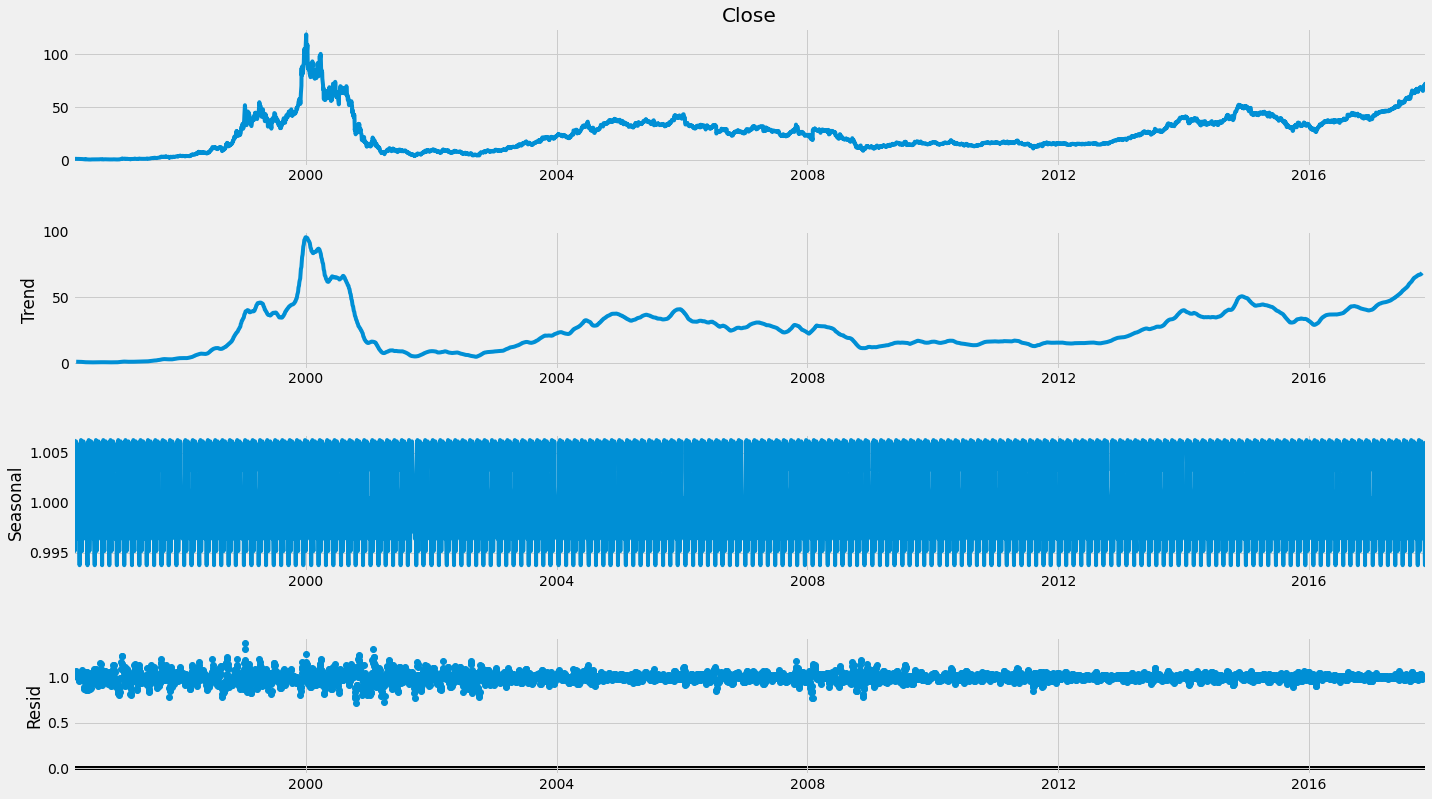

In [49]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 12)
plt.show()

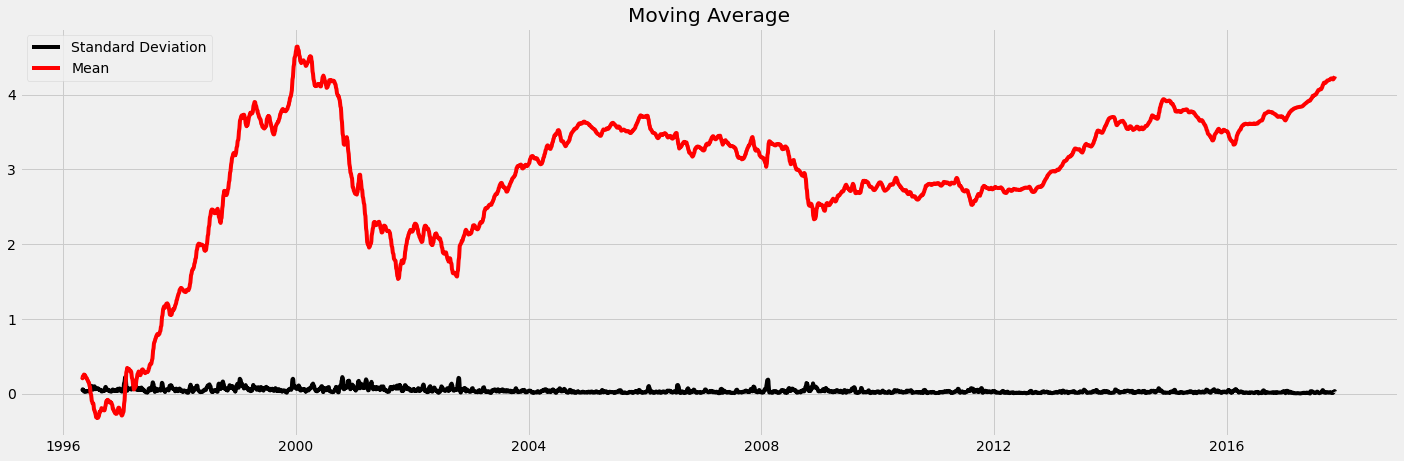

In [50]:
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

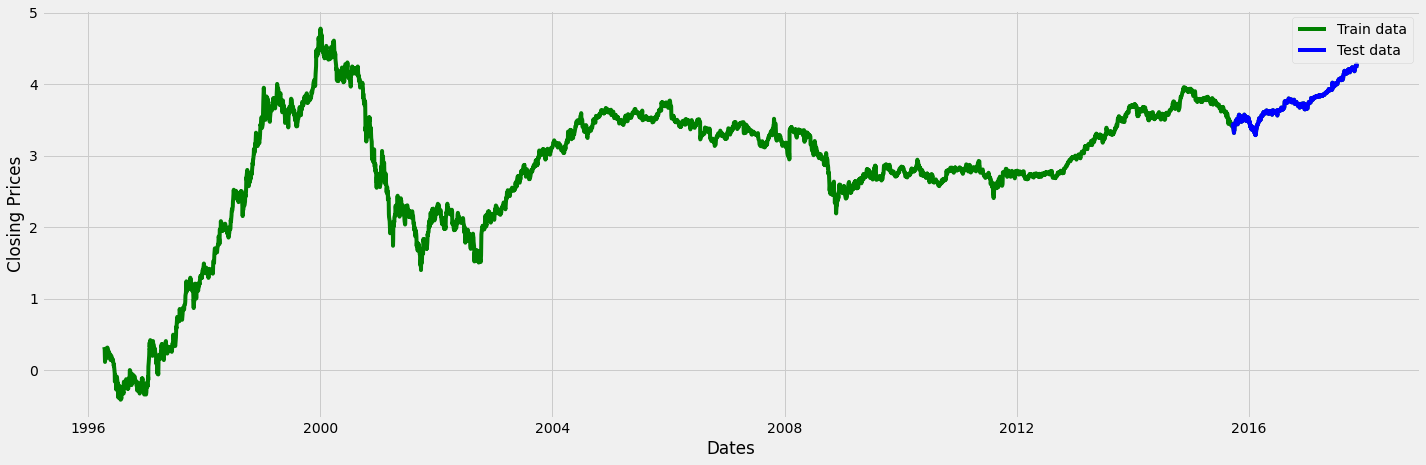

In [51]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend();

In [57]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18377.184, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18375.274, Time=0.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18375.280, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18377.513, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18378.090, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-18386.172, Time=1.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-18386.124, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-18384.395, Time=3.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-18384.593, Time=1.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-18386.043, Time=1.61 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-18386.390, Time=0.55 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-18384.620, Time=4.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-18382.617, Time=2.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-18386.638, Time=0.61 sec
 ARIM

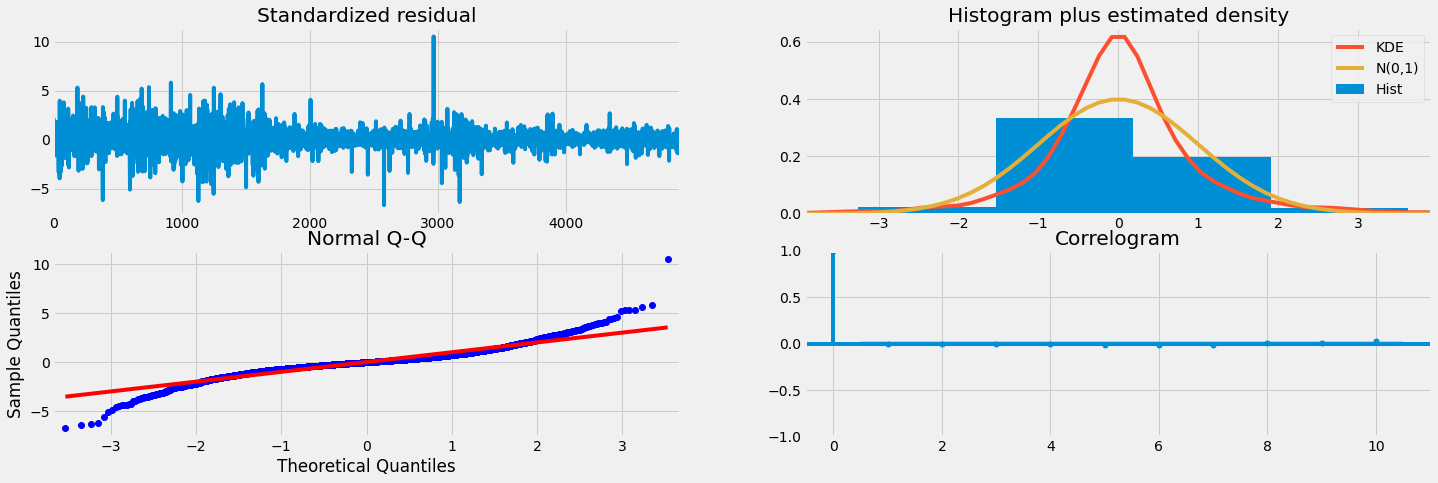

In [53]:
model_autoARIMA.plot_diagnostics()
plt.show()

**Top left:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.<br>

**Top Right:** The density plot suggest normal distribution with mean zero.<br>

**Bottom left:** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.<br>

**Bottom Right:** The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

In [58]:
model = ARIMA(train_data, order=(3, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4886
Model:                 ARIMA(3, 1, 0)   Log Likelihood                9198.196
Method:                       css-mle   S.D. of innovations              0.037
Date:                Tue, 31 Aug 2021   AIC                         -18386.391
Time:                        21:05:57   BIC                         -18353.920
Sample:                             1   HQIC                        -18374.997
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.001      1.325      0.185      -0.000       0.002
ar.L1.D.Close     0.0056      0.014      0.392      0.695      -0.022       0.034
ar.L2.D.Close    -0.0514      0.014     

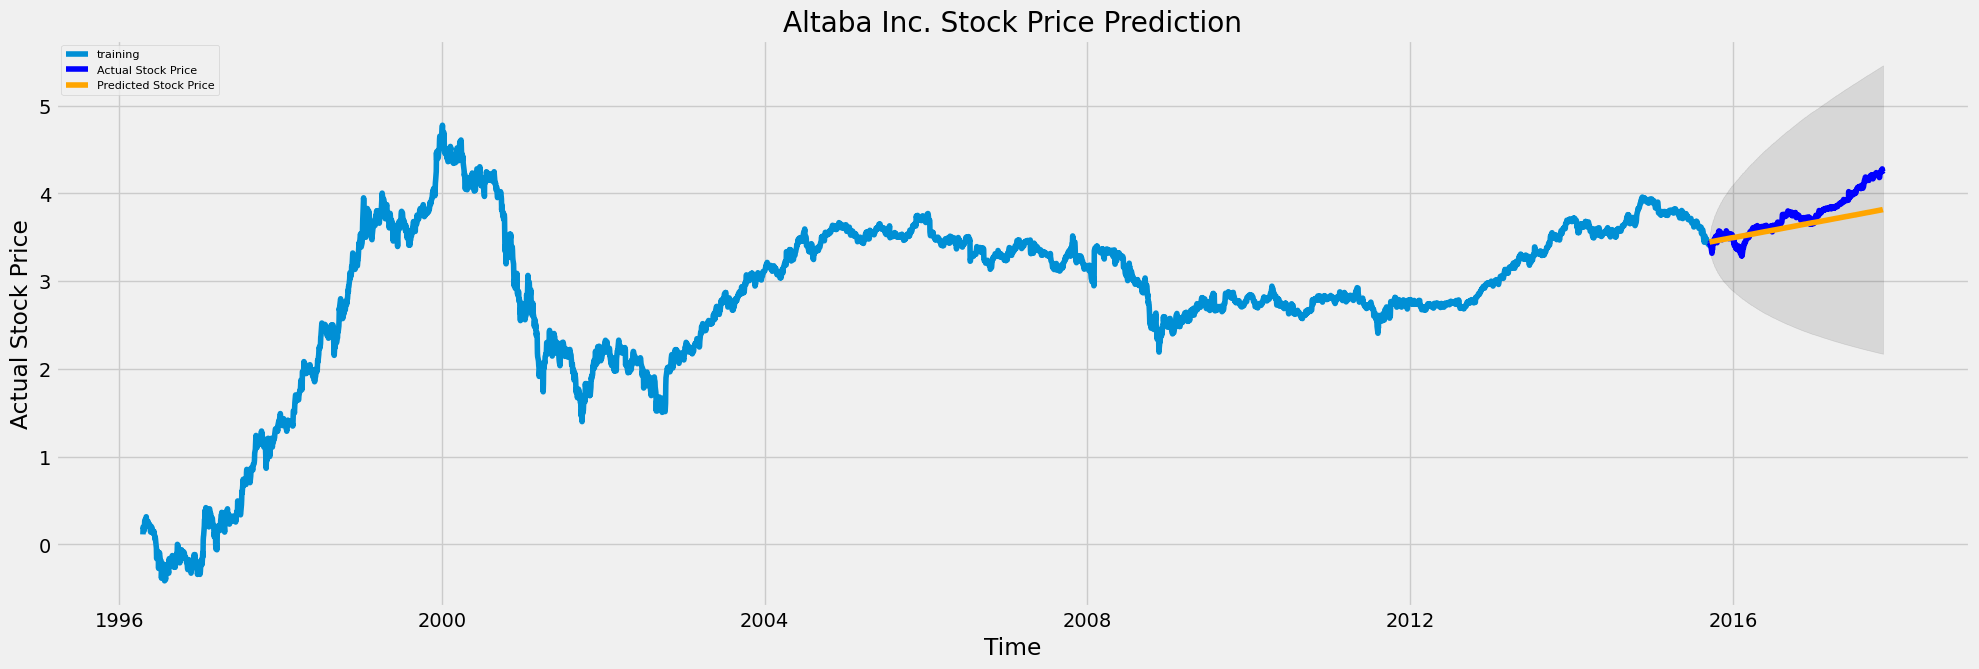

In [59]:
# Forecast
fc, se, conf = fitted.forecast(544, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure( dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [30]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.033311886704017975
MAE: 0.13801877238744675
RMSE: 0.182515442371373
MAPE: 0.03533046360302505


Around 3.5% MAPE(Mean Absolute Percentage Error) implies the model is about 96.5% accurate in predicting the test set observations.